In [1]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings
warnings.filterwarnings('ignore')

sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-')

symbols_list = sp500['Symbol'].to_list()

end_date = '2024-7-25'
start_date = pd.to_datetime(end_date) - pd.DateOffset(365 * 8)
df = yf.download(symbols_list, start_date, end_date)

df = df.stack()
df.index.names = ['date', 'ticker']
df.columns = df.columns.str.lower()

df

[*********************100%%**********************]  503 of 503 completed


Price               adj close       close        high         low        open  \
date       ticker                                                               
2016-07-27 A        44.382435   47.259998   47.459999   46.730000   47.000000   
           AAL      34.789043   36.200001   36.599998   35.900002   36.500000   
           AAPL     23.612217   25.737499   26.087500   25.687500   26.067499   
           ABBV     45.975037   64.900002   65.110001   64.320000   64.419998   
           ABT      37.723793   43.669998   43.900002   43.240002   43.570000   
...                       ...         ...         ...         ...         ...   
2024-07-24 XYL     136.347656  136.710007  140.619995  136.520004  140.020004   
           YUM     125.324677  125.949997  126.830002  124.760002  125.970001   
           ZBH     110.550003  110.550003  111.050003  109.510002  110.320000   
           ZBRA    322.089996  322.089996  330.739990  321.660004  328.399994   
           ZTS     179.660004  179.660004  180.839996  178.389999  179.330002   

Price                   volume  
date       ticker               
2016-07-27 A         1572600.0  
           AAL       6671200.0  
           AAPL    369379200.0  
           ABBV      6220400.0  
           ABT      15188200.0  
...                        ...  
2024-07-24 XYL       1010600.0  
           YUM       1620500.0  
           ZBH        925300.0  
           ZBRA       201900.0  
           ZTS       1309300.0  

[990197 rows x 6 columns]

In [2]:
df['garman_klass_vol'] = (((np.log(df['high']) - np.log(df['low']))**2) / 2) - ((2 * np.log(2) - 1)*((np.log(df['adj close']) - np.log(df['open']))**2))


df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))


def calculate_bbands(x,band_number):
    bbands = pandas_ta.bbands(close=np.log1p(x), length=20)
    return bbands.iloc[:,band_number] if bbands is not None else np.nan

bands = {
    'low' : 1,
    'mid' : 2,
    'high': 3
}

for band in bands.keys():
    df[f'bb_{band}'] = df.groupby(level=1)['adj close'].transform(calculate_bbands,bands[band])


def computeAtr(stock_data):
    atr = pandas_ta.atr(high = stock_data['high'],
                         low = stock_data['low'],
                         close=stock_data['close'],
                         length=14)
    return (atr.sub(atr.mean()) / atr.std()) if atr is not None else pd.Series([np.nan] * len(stock_data), index=stock_data.index)

df['atr'] = df.groupby(level=1, group_keys=False).apply(computeAtr)


def compute_macd(close):
    macd = pandas_ta.macd(close=close, length = 20)
    if macd is not None:
        macd = macd.iloc[:,0]
        return (macd.sub(macd.mean()) / macd.std())
    else:
        return pd.Series([np.nan] * len(close), index=close.index)

df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd)


df['dollar_volume'] = (df['adj close'] * df['volume']) / 1e6

df

Price               adj close       close        high         low        open  \
date       ticker                                                               
2016-07-27 A        44.382435   47.259998   47.459999   46.730000   47.000000   
           AAL      34.789043   36.200001   36.599998   35.900002   36.500000   
           AAPL     23.612217   25.737499   26.087500   25.687500   26.067499   
           ABBV     45.975037   64.900002   65.110001   64.320000   64.419998   
           ABT      37.723793   43.669998   43.900002   43.240002   43.570000   
...                       ...         ...         ...         ...         ...   
2024-07-24 XYL     136.347656  136.710007  140.619995  136.520004  140.020004   
           YUM     125.324677  125.949997  126.830002  124.760002  125.970001   
           ZBH     110.550003  110.550003  111.050003  109.510002  110.320000   
           ZBRA    322.089996  322.089996  330.739990  321.660004  328.399994   
           ZTS     179.660004  179.660004  180.839996  178.389999  179.330002   

Price                   volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                       
2016-07-27 A         1572600.0         -0.001148        NaN       NaN   
           AAL       6671200.0         -0.000704        NaN       NaN   
           AAPL    369379200.0         -0.003661        NaN       NaN   
           ABBV      6220400.0         -0.043881        NaN       NaN   
           ABT      15188200.0         -0.007904        NaN       NaN   
...                        ...               ...        ...       ...   
2024-07-24 XYL       1010600.0          0.000165  48.947302  4.920489   
           YUM       1620500.0          0.000125  37.398045  4.863439   
           ZBH        925300.0          0.000096  50.231086  4.693773   
           ZBRA       201900.0          0.000242  54.116719  5.768488   
           ZTS       1309300.0          0.000092  57.167415  5.179615   

Price                bb_mid   bb_high       atr      macd  dollar_volume  
date       ticker                                                         
2016-07-27 A            NaN       NaN       NaN       NaN      69.795817  
           AAL          NaN       NaN       NaN       NaN     232.084667  
           AAPL         NaN       NaN       NaN       NaN    8721.861807  
           ABBV         NaN       NaN       NaN       NaN     285.983118  
           ABT          NaN       NaN       NaN       NaN     572.956513  
...                     ...       ...       ...       ...            ...  
2024-07-24 XYL     4.959268  1.576225  0.993242  0.021820     137.792941  
           YUM     4.892066  1.177230  0.513210 -1.630886     203.088638  
           ZBH     4.726139  1.379112 -0.620580  0.001250     102.291918  
           ZBRA    5.823755  1.916180 -0.127372  0.510694      65.029970  
           ZTS     5.216505  1.424457  0.540415  0.741503     235.228843  

[990197 rows x 14 columns]

In [3]:
last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume', 'open', 'high', 'low', 'close']]

data = (pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'), df.unstack()[last_cols].resample('M').last().stack('ticker')], axis = 1)).dropna()

data['dollar_volume'] = data.loc[:, 'dollar_volume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack()

data['dollar_volume_rank'] = data.groupby('date')['dollar_volume'].rank(ascending=False)

data = data[data['dollar_volume_rank'] < 150].drop(['dollar_volume', 'dollar_volume_rank'], axis=1)

def calculateReturns(df):
    outliner_cutoff = 0.005
    lags = [1, 2, 3, 6, 9, 12]
    for lag in lags:
        df[f'return_{lag}m'] = (df['adj close']
                                .pct_change(lag)
                                .pipe(lambda x : x.clip(lower = x.quantile(outliner_cutoff), upper = x.quantile(1 - outliner_cutoff)))
                                .add(1)
                                .pow(1/lag)
                                .sub(1))
    return df

data = data.groupby(level=1, group_keys=False).apply(calculateReturns).dropna()
                                
data

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2018-07-31 AAL      38.702713          0.000092  49.117697  3.645691   
           AAPL     45.171410         -0.000930  52.605306  3.833190   
           ABBV     70.257545         -0.027194  45.920979  4.279128   
           ABT      59.123001         -0.003867  62.882467  4.062819   
           ACN     145.464844         -0.003530  42.887879  5.023605   
...                       ...               ...        ...       ...   
2024-07-31 VRTX    490.799988          0.000060  62.645394  6.182992   
           VZ       39.669998          0.000150  46.351207  3.731003   
           WFC      58.989357          0.000032  51.103412  4.092111   
           WMT      70.399330          0.000024  64.343789  4.253081   
           XOM     114.091469          0.000171  51.591686  4.741506   

                     bb_mid   bb_high       atr      macd  return_1m  \
date       ticker                                                      
2018-07-31 AAL     3.699472  2.950396  0.806043 -0.288702   0.041623   
           AAPL    3.859331  1.363896 -1.091720 -0.181003   0.027984   
           ABBV    4.332605  2.499441  0.026626 -0.726600   0.005634   
           ABT     4.109713  2.308454 -0.958409  0.539323   0.079433   
           ACN     5.054037  1.211566 -0.853919 -0.180235  -0.026040   
...                     ...       ...       ...       ...        ...   
2024-07-31 VRTX    6.219522  1.181605  1.125810  1.329293   0.047107   
           VZ      3.770938  2.140755 -0.037520  0.021715  -0.022328   
           WFC     4.133247  2.010538  0.891972  0.076624   0.000842   
           WMT     4.285338  1.516872  0.710825  1.729791   0.042682   
           XOM     4.772826  1.321099  0.580123  0.265154  -0.000956   

                   return_2m  return_3m  return_6m  return_9m  return_12m  
date       ticker                                                          
2018-07-31 AAL     -0.047041  -0.026289  -0.050880  -0.017899   -0.019393  
           AAPL     0.009109   0.049478   0.022909   0.014540    0.022060  
           ABBV    -0.029587  -0.011801  -0.028860   0.005495    0.026310  
           ABT      0.034388   0.042361   0.010427   0.022867    0.025837  
           ACN      0.011460   0.017611   0.000037   0.013581    0.019435  
...                      ...        ...        ...        ...         ...  
2024-07-31 VRTX     0.038208   0.077062   0.020953   0.034365    0.028005  
           VZ      -0.010146   0.006951  -0.005498   0.019132    0.018674  
           WFC     -0.004013   0.002588   0.030812   0.048176    0.023800  
           WMT      0.036147   0.060787   0.043423   0.030448    0.024927  
           XOM     -0.009641  -0.006599   0.021814   0.012234    0.008751  

[10508 rows x 14 columns]

In [4]:
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3','famafrench', start=2010)[0].drop('RF', axis = 1)
factor_data.index = factor_data.index.to_timestamp()
factor_data = factor_data.resample('M').last().div(100)
factor_data.index.name = 'date'
factor_data = factor_data.join(data['return_1m']).sort_index()

observations = factor_data.groupby(level=1).size()
valid_stocks = observations[observations >= 10]
factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]

betas = (factor_data.groupby(level=1, group_keys=False)
        .apply(lambda x: RollingOLS(endog=x['return_1m'],
                                    exog=sm.add_constant(x.drop('return_1m', axis = 1)),
                                    window = min(24, x.shape[0]),
                                    min_nobs = len(x.columns) + 1)
        .fit(params_only=True)
        .params
        .drop('const', axis=1)))

data.join(betas.groupby('ticker').shift())
data = data.join(betas.groupby('ticker').shift())
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']
data.loc[:, factors] = data.groupby('ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))

data = data.dropna()

data = data.drop('adj close', axis = 1)

data

garman_klass_vol        rsi    bb_low    bb_mid   bb_high  \
date       ticker                                                              
2018-07-31 AAL             0.000092  49.117697  3.645691  3.699472  2.950396   
           AAPL           -0.000930  52.605306  3.833190  3.859331  1.363896   
           ABBV           -0.027194  45.920979  4.279128  4.332605  2.499441   
           ABT            -0.003867  62.882467  4.062819  4.109713  2.308454   
           ACN            -0.003530  42.887879  5.023605  5.054037  1.211566   
...                             ...        ...       ...       ...       ...   
2024-07-31 VRTX            0.000060  62.645394  6.182992  6.219522  1.181605   
           VZ              0.000150  46.351207  3.731003  3.770938  2.140755   
           WFC             0.000032  51.103412  4.092111  4.133247  2.010538   
           WMT             0.000024  64.343789  4.253081  4.285338  1.516872   
           XOM             0.000171  51.591686  4.741506  4.772826  1.321099   

                        atr      macd  return_1m  return_2m  return_3m  \
date       ticker                                                        
2018-07-31 AAL     0.806043 -0.288702   0.041623  -0.047041  -0.026289   
           AAPL   -1.091720 -0.181003   0.027984   0.009109   0.049478   
           ABBV    0.026626 -0.726600   0.005634  -0.029587  -0.011801   
           ABT    -0.958409  0.539323   0.079433   0.034388   0.042361   
           ACN    -0.853919 -0.180235  -0.026040   0.011460   0.017611   
...                     ...       ...        ...        ...        ...   
2024-07-31 VRTX    1.125810  1.329293   0.047107   0.038208   0.077062   
           VZ     -0.037520  0.021715  -0.022328  -0.010146   0.006951   
           WFC     0.891972  0.076624   0.000842  -0.004013   0.002588   
           WMT     0.710825  1.729791   0.042682   0.036147   0.060787   
           XOM     0.580123  0.265154  -0.000956  -0.009641  -0.006599   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2018-07-31 AAL     -0.050880  -0.017899   -0.019393  1.213959  1.513005   
           AAPL     0.022909   0.014540    0.022060  1.314183 -0.315318   
           ABBV    -0.028860   0.005495    0.026310  0.471209  0.507530   
           ABT      0.010427   0.022867    0.025837  0.788181 -0.135120   
           ACN      0.000037   0.013581    0.019435  1.212995 -0.192134   
...                      ...        ...         ...       ...       ...   
2024-07-31 VRTX     0.020953   0.034365    0.028005  0.504530  0.103891   
           VZ      -0.005498   0.019132    0.018674  0.469834 -0.471297   
           WFC      0.030812   0.048176    0.023800  1.087685 -0.085023   
           WMT      0.043423   0.030448    0.024927  0.616306 -0.383710   
           XOM      0.021814   0.012234    0.008751  1.066419  0.131474   

                        HML       RMW       CMA  
date       ticker                                
2018-07-31 AAL     0.370547  0.178105  0.836323  
           AAPL   -0.626313  0.432607  0.605910  
           ABBV   -0.206893  0.544084  0.489798  
           ABT    -0.435130  0.223148  0.937490  
           ACN    -0.261593  0.324795  0.092280  
...                     ...       ...       ...  
2024-07-31 VRTX   -0.876672  0.087951  0.841036  
           VZ      0.241101  0.183800  0.206243  
           WFC     1.555132 -0.725309 -0.864723  
           WMT    -0.368530  0.221575  0.676839  
           XOM     0.845784 -0.468164  0.426275  

[10287 rows x 18 columns]

In [5]:
target_rsi_values = [30, 45, 55, 70]

initial_centroids = np.zeros((len(target_rsi_values), 18))

initial_centroids[:, 1] = target_rsi_values

from sklearn.cluster import KMeans

def get_cluster(df):
    df['cluster'] = KMeans(n_clusters=4,
                           random_state=0,
                           init=initial_centroids).fit(df).labels_
    return df

data = data.dropna().groupby('date', group_keys=False).apply(get_cluster)
data

garman_klass_vol        rsi    bb_low    bb_mid   bb_high  \
date       ticker                                                              
2018-07-31 AAL             0.000092  49.117697  3.645691  3.699472  2.950396   
           AAPL           -0.000930  52.605306  3.833190  3.859331  1.363896   
           ABBV           -0.027194  45.920979  4.279128  4.332605  2.499441   
           ABT            -0.003867  62.882467  4.062819  4.109713  2.308454   
           ACN            -0.003530  42.887879  5.023605  5.054037  1.211566   
...                             ...        ...       ...       ...       ...   
2024-07-31 VRTX            0.000060  62.645394  6.182992  6.219522  1.181605   
           VZ              0.000150  46.351207  3.731003  3.770938  2.140755   
           WFC             0.000032  51.103412  4.092111  4.133247  2.010538   
           WMT             0.000024  64.343789  4.253081  4.285338  1.516872   
           XOM             0.000171  51.591686  4.741506  4.772826  1.321099   

                        atr      macd  return_1m  return_2m  return_3m  \
date       ticker                                                        
2018-07-31 AAL     0.806043 -0.288702   0.041623  -0.047041  -0.026289   
           AAPL   -1.091720 -0.181003   0.027984   0.009109   0.049478   
           ABBV    0.026626 -0.726600   0.005634  -0.029587  -0.011801   
           ABT    -0.958409  0.539323   0.079433   0.034388   0.042361   
           ACN    -0.853919 -0.180235  -0.026040   0.011460   0.017611   
...                     ...       ...        ...        ...        ...   
2024-07-31 VRTX    1.125810  1.329293   0.047107   0.038208   0.077062   
           VZ     -0.037520  0.021715  -0.022328  -0.010146   0.006951   
           WFC     0.891972  0.076624   0.000842  -0.004013   0.002588   
           WMT     0.710825  1.729791   0.042682   0.036147   0.060787   
           XOM     0.580123  0.265154  -0.000956  -0.009641  -0.006599   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2018-07-31 AAL     -0.050880  -0.017899   -0.019393  1.213959  1.513005   
           AAPL     0.022909   0.014540    0.022060  1.314183 -0.315318   
           ABBV    -0.028860   0.005495    0.026310  0.471209  0.507530   
           ABT      0.010427   0.022867    0.025837  0.788181 -0.135120   
           ACN      0.000037   0.013581    0.019435  1.212995 -0.192134   
...                      ...        ...         ...       ...       ...   
2024-07-31 VRTX     0.020953   0.034365    0.028005  0.504530  0.103891   
           VZ      -0.005498   0.019132    0.018674  0.469834 -0.471297   
           WFC      0.030812   0.048176    0.023800  1.087685 -0.085023   
           WMT      0.043423   0.030448    0.024927  0.616306 -0.383710   
           XOM      0.021814   0.012234    0.008751  1.066419  0.131474   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2018-07-31 AAL     0.370547  0.178105  0.836323        1  
           AAPL   -0.626313  0.432607  0.605910        2  
           ABBV   -0.206893  0.544084  0.489798        1  
           ABT    -0.435130  0.223148  0.937490        3  
           ACN    -0.261593  0.324795  0.092280        1  
...                     ...       ...       ...      ...  
2024-07-31 VRTX   -0.876672  0.087951  0.841036        3  
           VZ      0.241101  0.183800  0.206243        1  
           WFC     1.555132 -0.725309 -0.864723        2  
           WMT    -0.368530  0.221575  0.676839        3  
           XOM     0.845784 -0.468164  0.426275        2  

[10287 rows x 19 columns]

In [ ]:
def plot_cluster(data):

    cluster_0 = data[data['cluster'] == 0]
    cluster_1 = data[data['cluster'] == 1]
    cluster_2 = data[data['cluster'] == 2]
    cluster_3 = data[data['cluster'] == 3]

    plt.scatter(cluster_0.iloc[:,0], cluster_0.iloc[:,6], color = 'red', label = 'cluster 0')
    plt.scatter(cluster_1.iloc[:,0], cluster_1.iloc[:,6], color = 'green', label = 'cluster 1')
    plt.scatter(cluster_2.iloc[:,0], cluster_2.iloc[:,6], color = 'blue', label = 'cluster 2')
    plt.scatter(cluster_3.iloc[:,0], cluster_3.iloc[:,6], color = 'black', label = 'cluster 3')

    plt.legend()
    plt.show()
    return

In [ ]:
# plt.style.use('ggplot')

# for i in data.index.get_level_values('date').unique().to_list():
#     g = data.xs(i, level=0)

#     plt.title(f'Date {i}')
    
#     plot_cluster(g)

In [6]:
filtered_df = data[data['cluster'] == 3].copy()

filtered_df = filtered_df.reset_index(level=1)

filtered_df.index = filtered_df.index + pd.DateOffset(1)

filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])
filtered_df


garman_klass_vol        rsi    bb_low    bb_mid   bb_high  \
date       ticker                                                              
2018-08-01 ABT            -0.003867  62.882467  4.062819  4.109713  2.308454   
           AMD             0.000990  62.989022  2.879040  2.996691  8.172977   
           AMGN           -0.009278  62.795900  5.077591  5.105530  1.100501   
           AMT            -0.006340  63.393106  4.828327  4.853770  1.053923   
           BDX            -0.001977  64.195149  5.405572  5.428742  0.857271   
...                             ...        ...       ...       ...       ...   
2024-08-01 T               0.000245  61.126903  2.980940  3.008395  1.842046   
           UNH             0.000106  66.231568  6.252881  6.372658  3.831087   
           USB             0.000184  65.830870  3.754359  3.865340  5.912088   
           VRTX            0.000060  62.645394  6.182992  6.219522  1.181605   
           WMT             0.000024  64.343789  4.253081  4.285338  1.516872   

                        atr      macd  return_1m  return_2m  return_3m  \
date       ticker                                                        
2018-08-01 ABT    -0.958409  0.539323   0.079433   0.034388   0.042361   
           AMD    -0.918362  0.086722   0.222815   0.155436   0.189902   
           AMGN   -0.820912  0.325902   0.064792   0.046066   0.043171   
           AMT    -0.826282  0.138635   0.028230   0.037939   0.030148   
           BDX    -0.704658  1.048539   0.045124   0.064683   0.027028   
...                     ...       ...        ...        ...        ...   
2024-08-01 T      -0.193926  1.003274   0.017665   0.033139   0.048122   
           UNH     1.411081  3.660009   0.099144   0.065250   0.051362   
           USB    -0.161749  1.806299   0.127708   0.057295   0.037160   
           VRTX    1.125810  1.329293   0.047107   0.038208   0.077062   
           WMT     0.710825  1.729791   0.042682   0.036147   0.060787   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2018-08-01 ABT      0.010427   0.022867    0.025837  0.788181 -0.135120   
           AMD      0.049210   0.058486    0.025122  1.982306 -1.213777   
           AMGN     0.011755   0.015328    0.012383  0.732853  0.068231   
           AMT      0.002415   0.005249    0.008744  0.643055 -0.122345   
           BDX      0.006152   0.021595    0.019472  0.721755 -0.385276   
...                      ...        ...         ...       ...       ...   
2024-08-01 T        0.018667   0.029972    0.029043  0.559131 -0.073496   
           UNH      0.016441   0.006214    0.009687  0.648490  0.018704   
           USB      0.016574   0.042491    0.014312  0.797925  0.268747   
           VRTX     0.020953   0.034365    0.028005  0.504530  0.103891   
           WMT      0.043423   0.030448    0.024927  0.616306 -0.383710   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2018-08-01 ABT    -0.435130  0.223148  0.937490        3  
           AMD    -0.342507 -0.778215 -0.034185        3  
           AMGN   -0.398438  0.478514  1.336228        3  
           AMT    -0.380319  0.374007  0.414284        3  
           BDX    -0.204795 -0.806399  1.222656        3  
...                     ...       ...       ...      ...  
2024-08-01 T       0.384962  0.284309  0.458482        3  
           UNH    -0.185702  0.273915  0.371422        3  
           USB     1.492772 -0.413337 -0.974116        3  
           VRTX   -0.876672  0.087951  0.841036        3  
           WMT    -0.368530  0.221575  0.676839        3  

[1927 rows x 19 columns]

In [7]:
dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {}

for d in dates:
    fixed_dates[d.strftime("%Y-%m-%d")] = filtered_df.xs(d, level=0).index.tolist()


In [8]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from scipy.optimize import minimize
def optimize_weights(prices, lower_bound = 0):
    returns = expected_returns.mean_historical_return(prices=prices,frequency=252)

    cov = risk_models.sample_cov(prices=prices, frequency=252)

    ef = EfficientFrontier(expected_returns=returns, cov_matrix=cov, weight_bounds=(lower_bound,.1), solver = 'SCS')

    weights = ef.max_sharpe()

    return ef.clean_weights()

In [9]:
stocks = data.index.get_level_values('ticker').unique().tolist()

new_df = yf.download(tickers = stocks, start = data.index.get_level_values('date').unique()[0] - pd.DateOffset(months=12),
                     end = data.index.get_level_values('date').unique()[-1])

[*********************100%%**********************]  154 of 154 completed


In [11]:
returns_dataframe = np.log(new_df['Adj Close']).diff()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():

    try:
        end_date = (pd.to_datetime(start_date) + pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')

        cols = fixed_dates[start_date]

        optimization_start_date = (pd.to_datetime(start_date) - pd.DateOffset(years=1)).strftime('%Y-%m-%d')

        optimization_end_date = (pd.to_datetime(start_date) - pd.DateOffset(days=1)).strftime('%Y-%m-%d')

        optimization_df = new_df[optimization_start_date:optimization_end_date]['Adj Close'][cols]

        success = False
        try:
            weights = optimize_weights(prices = optimization_df, lower_bound = round(1/(len(optimization_df.columns)*2), 3))

            weights = pd.DataFrame(weights, index=pd.Series(0))

            success = True
        except:
            print(f'Max Sharpe Optimiztion failed for {start_date}, Continuing with Equal-Weights')

        if success == False:
            weights = pd.DataFrame([1/len(optimization_df.columns) for i in range(len(optimization_df.columns))],
                                    index = optimization_df.columns.tolist(),
                                    columns=pd.Series(0)).T

        temp_df = returns_dataframe[start_date:end_date]

        temp_df = temp_df.stack().to_frame('return').reset_index(level=0)\
                            .merge(weights.stack().to_frame('weight').reset_index(level=0, drop=True), 
                                left_index = True, right_index = True)\
                            .reset_index().set_index(['Date', 'Ticker']).unstack().stack()
            
        temp_df.index.names = ['date', 'ticker']

        temp_df['weighted_return'] = temp_df['return'] * temp_df['weight']

        temp_df = temp_df.groupby(level=0)['weighted_return'].sum().to_frame('Strategy Return')

        portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)
    except Exception as e:
        print(e)
    

Max Sharpe Optimiztion failed for 2019-01-01, Continuing with Equal-Weights
Max Sharpe Optimiztion failed for 2019-06-01, Continuing with Equal-Weights
Max Sharpe Optimiztion failed for 2020-03-01, Continuing with Equal-Weights
Max Sharpe Optimiztion failed for 2020-04-01, Continuing with Equal-Weights
Max Sharpe Optimiztion failed for 2021-02-01, Continuing with Equal-Weights
Max Sharpe Optimiztion failed for 2021-10-01, Continuing with Equal-Weights
Max Sharpe Optimiztion failed for 2022-07-01, Continuing with Equal-Weights
Max Sharpe Optimiztion failed for 2022-09-01, Continuing with Equal-Weights
Max Sharpe Optimiztion failed for 2022-10-01, Continuing with Equal-Weights
Max Sharpe Optimiztion failed for 2023-11-01, Continuing with Equal-Weights
'return'


In [14]:
spy = yf.download(tickers='SPY',
                  start='2015-01-01',
                  end=dt.date.today())

spy_ret = np.log(spy[['Adj Close']]).diff().dropna().rename({'Adj Close': 'SPY Buy&Hold'}, axis=1)

portfolio_df = portfolio_df.merge(spy_ret, left_index=True, right_index=True)

[*********************100%%**********************]  1 of 1 completed


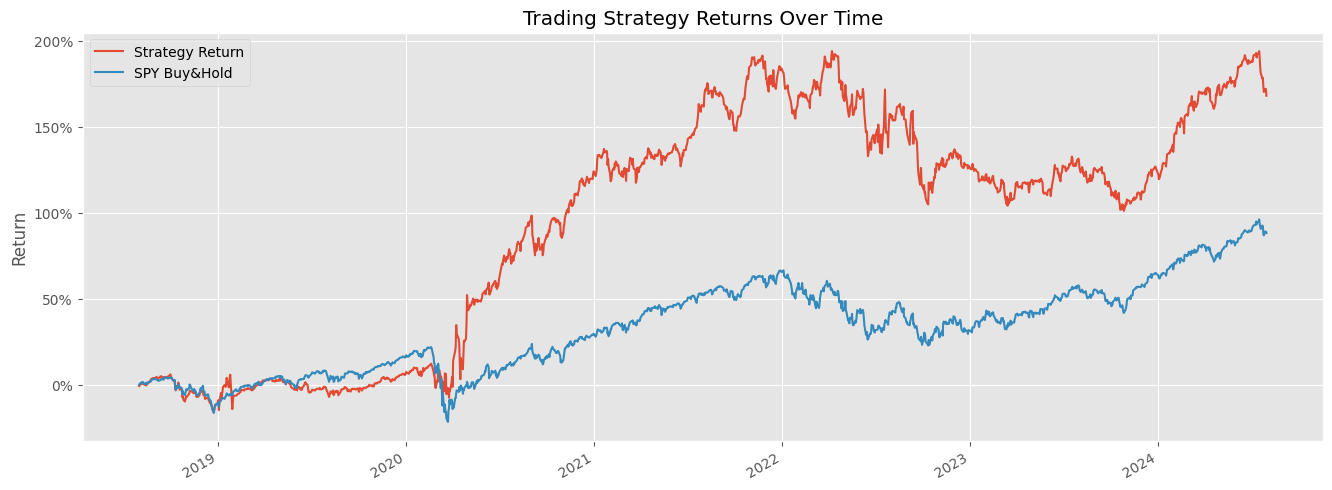

In [16]:
import matplotlib.ticker as mtick

plt.style.use('ggplot')

portfolio_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum()) - 1

portfolio_cumulative_return[:'2024-07-30'].plot(figsize=(16,6))

plt.title('Trading Strategy Returns Over Time')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()